In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [23]:
data = pd.read_csv("apple_stock_data.csv")

In [24]:
data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-06-18 00:00:00-04:00,85.398704,85.894461,84.866495,85.476471,96820400,0.0,0.0
1,2020-06-19 00:00:00-04:00,86.183655,86.650244,83.877416,84.988007,264476000,0.0,0.0
2,2020-06-22 00:00:00-04:00,85.381697,87.354996,85.335523,87.211617,135445200,0.0,0.0
3,2020-06-23 00:00:00-04:00,88.458294,90.494780,88.037872,89.073128,212155600,0.0,0.0
4,2020-06-24 00:00:00-04:00,88.701292,89.622329,87.126537,87.500786,192623200,0.0,0.0


In [25]:
import matplotlib.pyplot as plt

In [26]:
df=data.reset_index()['Close']
df

0        85.476471
1        84.988007
2        87.211617
3        89.073128
4        87.500786
           ...    
1252    199.199997
1253    196.449997
1254    198.419998
1255    195.639999
1256    196.205002
Name: Close, Length: 1257, dtype: float64

In [27]:
df.shape

(1257,)

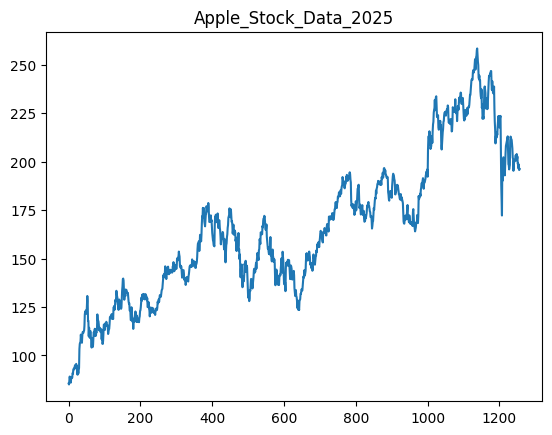

In [28]:
plt.title(label="Apple_Stock_Data_2025")
plt.plot(df)

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [30]:
print(df)

[[0.00281684]
 [0.        ]
 [0.01282295]
 ...
 [0.65413106]
 [0.63809957]
 [0.64135779]]


#### Spliting Data into Train and Test

In [31]:
training_size=int(len(df)*0.65)
test_size=len(df)-training_size
train_data=df[0:training_size,:]
test_data=df[training_size:len(df),:1]

In [32]:
training_size,test_size

(817, 440)

Formating Data into Series

In [33]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [],[]
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0] 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [34]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [35]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

##LSTM requires 3-dimensions as an input

Creating LSTM Model 

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [40]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [44]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/',histogram_freq=1)

In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1,  restore_best_weights=True)

In [41]:
model_checkpoint = ModelCheckpoint("chechkpoint.model.keras", monitor='val_loss', save_best_only=True, verbose=1)

In [45]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1,callbacks=[early_stopping, model_checkpoint, tb_callback])

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 4.2982e-04 - accuracy: 0.0000e+00
Epoch 1: val_loss did not improve from 0.00078
12/12 [==============================] - 2s 177ms/step - loss: 4.2982e-04 - accuracy: 0.0000e+00 - val_loss: 9.1903e-04 - val_accuracy: 0.0029
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 3.9825e-04 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 0.00078 to 0.00075, saving model to chechkpoint.model.keras
12/12 [==============================] - 2s 160ms/step - loss: 3.9825e-04 - accuracy: 0.0000e+00 - val_loss: 7.5125e-04 - val_accuracy: 0.0029
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 3.6305e-04 - accuracy: 0.0000e+00
Epoch 3: val_loss did not improve from 0.00075
12/12 [==============================] - 2s 156ms/step - loss: 3.6305e-04 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0029
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 5.2989e-04 

In [91]:
##Tensorboard
#%load_ext tensorboard
#%tensorboard --logdir logs/

Testing with Test Data

In [47]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 27ms/step


In [48]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [49]:
import math

In [51]:
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

150.4430662488075
212.235090242068


#### Plotting the Data for Forecasting

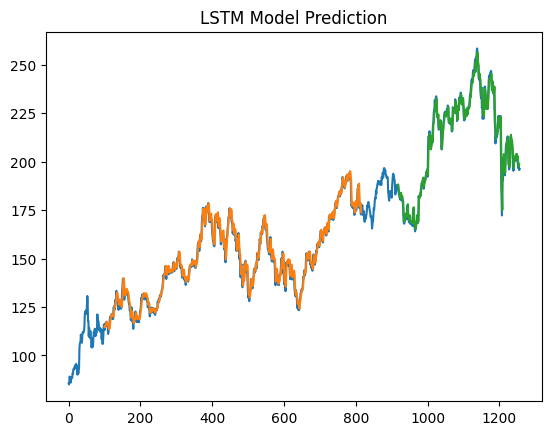

In [53]:
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.title(label="LSTM Model Prediction")
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [60]:
len(test_data)

440

In [78]:
x_input=test_data[len(test_data)-200:].reshape(1,-1)
x_input.shape

(1, 200)

#### Predicting the Next Upcoming Closing'Price

In [79]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

## Creating list of next 30 days and predicting the output

In [81]:
lst_output=[]
n_steps=199
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output[0])


0 day input [0.79005087 0.77901757 0.78780977 0.77884519 0.77936242 0.77476512
 0.78941881 0.79005087 0.78849937 0.75298592 0.75568661 0.77809822
 0.82510473 0.8212545  0.81131311 0.81648483 0.81073834 0.8173469
 0.8188984  0.84883792 0.80981899 0.81309445 0.80671582 0.81320937
 0.78384471 0.80729059 0.82895479 0.82608155 0.81751937 0.83906882
 0.85372242 0.84182706 0.84395332 0.86033089 0.8688357  0.86527294
 0.83596565 0.83487383 0.83970096 0.85113648 0.85268806 0.83217297
 0.80809503 0.79085539 0.7856835  0.79395856 0.78976357 0.81711706
 0.8155638  0.79985851 0.79985851 0.80497848 0.82281233 0.80428817
 0.82166173 0.82315753 0.82729955 0.82453823 0.83230452 0.84956307
 0.86216177 0.86141391 0.87522075 0.88822219 0.90582594 0.90789695
 0.90806951 0.90691891 0.92941262 0.93528054 0.92791691 0.93637359
 0.93735154 0.95409235 0.9681292  0.93689134 0.94690127 0.97393975
 0.97842696 0.99528286 1.         0.98026778 0.96076558 0.95052554
 0.91272945 0.9099105  0.91934514 0.90329473 0.9061

In [82]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [72]:
day_new

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [83]:
len(df)

1257

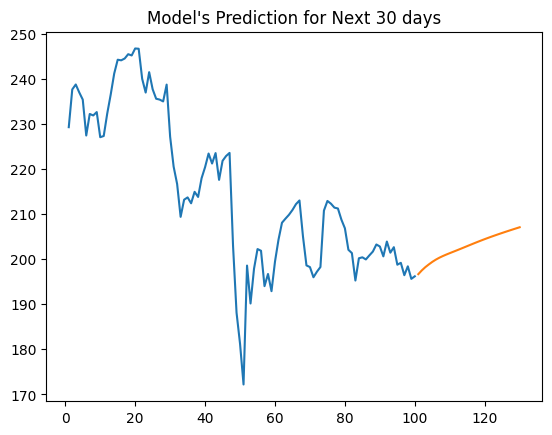

In [84]:
plt.title(label="Model's Prediction for Next 30 days")
plt.plot(day_new,scaler.inverse_transform(df[len(df)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

## Connecting The Whole Graph

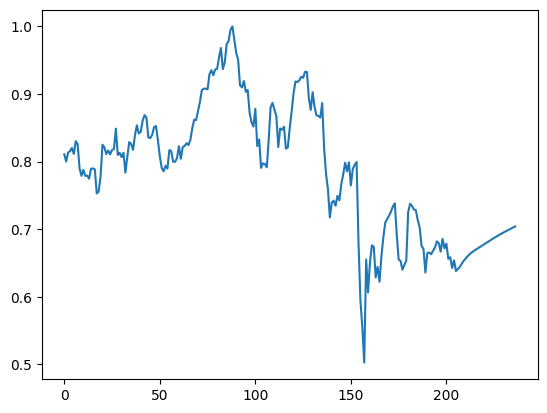

In [87]:
df_new=df.tolist()
df_new.extend(lst_output)
plt.plot(df_new[1050:])

In [89]:
df_new=scaler.inverse_transform(df_new).tolist()

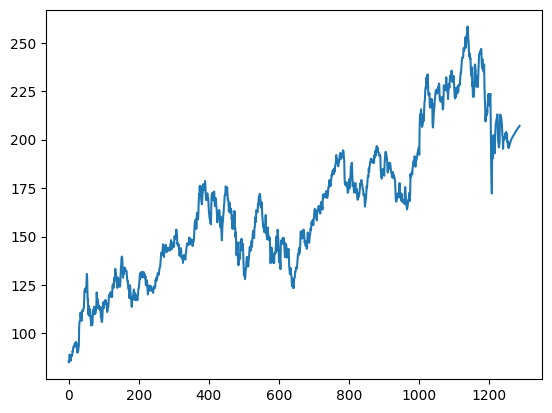

In [90]:
plt.plot(df_new)

In [92]:
model.save("lstm_model.h5")